In [49]:
import os
import sys
import torch
import torch_geometric as tg
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

gat_path = os.path.abspath(os.path.join(os.getcwd(), '../../kally/src'))
sys.path.append(gat_path)
from gat import GATv2

In [30]:
GATV2_MODEL_FNAME = '../best-configs-cora/gatv2163.pt'
assert(os.path.isfile(GATV2_MODEL_FNAME))

In [32]:
UT_MODEL_FNAME = '../best-configs-cora/ut-small-dropout-annealing73.pt'
assert(os.path.isfile(UT_MODEL_FNAME))

In [22]:
device = torch.device('cuda:0')

In [23]:
dataset = tg.datasets.Planetoid(root='data', name='Cora', split='full')
cora_dataloader = tg.loader.DataLoader(dataset)
cora_graph = next(iter(cora_dataloader))

nodes = cora_graph.x.to(device)
y = cora_graph.y.to(device)
adjacency_matrix = tg.utils.to_dense_adj(cora_graph.edge_index).squeeze(dim=0).to(device)

train_mask = cora_graph.train_mask.to(device)
test_mask = cora_graph.test_mask.to(device)
val_mask = cora_graph.val_mask.to(device)

In [50]:
display_mask = torch.zeros(train_mask.shape, dtype=train_mask.dtype)
G = nx.from_numpy_matrix(adjacency_matrix.cpu().numpy())
display_mask[np.array(nx.max_weight_clique(G, weight=None)[0], dtype=np.int32)] = True

In [31]:
gatv2_first_layer = torch.load(GATV2_MODEL_FNAME).layers[0].to(device)

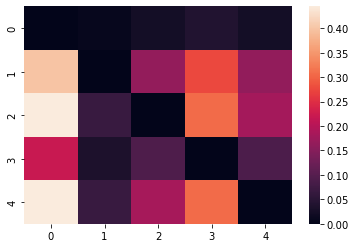

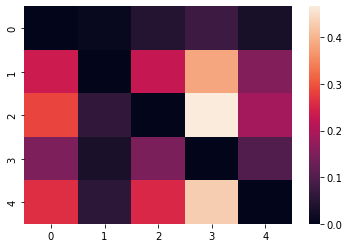

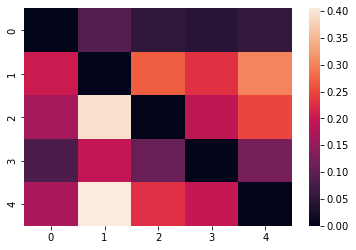

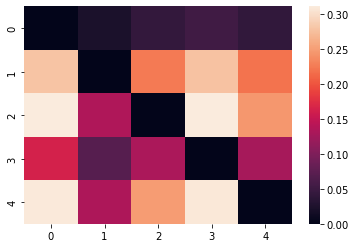

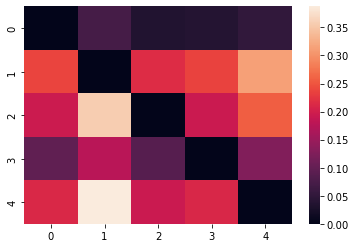

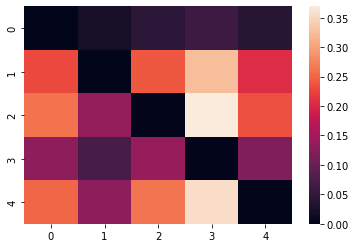

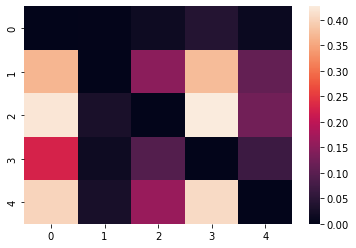

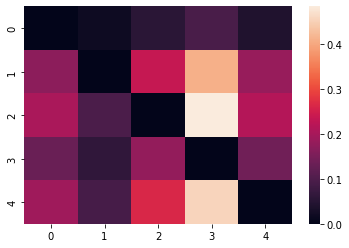

In [51]:
with torch.no_grad():
        hidden_repr = torch.einsum('jk,ikl->ijl', nodes, gatv2_first_layer.W)
        activated_hidden_repr = gatv2_first_layer.attention_activation(hidden_repr)

        first_half_full_attn = torch.einsum(
            'ijl,il->ij', activated_hidden_repr, gatv2_first_layer.shared_attention[:, :gatv2_first_layer.repr_dim])
        second_half_full_attn = torch.einsum(
            'ijl,il->ij', activated_hidden_repr, gatv2_first_layer.shared_attention[:, gatv2_first_layer.repr_dim:])
        full_attn = torch.unsqueeze(first_half_full_attn, 2) \
            + torch.unsqueeze(second_half_full_attn, 1) # result shape n_heads x N x N

        # masking out non-neighbourhood regions and summing using the attention weights
        neighbourhood_attention = gatv2_first_layer.softmax(
            full_attn + torch.unsqueeze(-1.0e16 * (1-adjacency_matrix), 0))

        for i in range(neighbourhood_attention.shape[0]):
            sns.heatmap(neighbourhood_attention[i, :, :][display_mask, :][:, display_mask].cpu())
            plt.show()